# **Question Pair Similarity Classification**

## **Introduction**
The goal of this project is to develop an advanced question pair similarity classification system that leverages text preprocessing, exploratory data analysis, and machine learning techniques to accurately identify whether two questions are semantically similar (duplicates) or not. 

This imports the necessary libraries for data handling, visualization, and text preprocessing.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup

In [4]:
#Readling the datasets
df = pd.read_csv("/kaggle/input/train-csv/train.csv")
df.shape

(404290, 6)

Since the train.csv file contains 404,290 rows and 6 columns, training the model on the entire dataset would require significant computational time. To optimize the process, I sampled 50,000 rows from the dataset and set a random state of 2. This randomly selects a subset of 50,000 rows from the dataset for faster processing.

In [5]:
df = df.sample(50000,random_state=2)

## Exploratory Data Analysis (EDA):

In [6]:
df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0
244531,244531,145041,264664,I killed a snake on a Friday. There's a belief...,Do snakes really take revenge?,0
16633,16633,31698,31699,Is the royal family a net gain or a net loss t...,Why does the British royal family think it's O...,0
396316,396316,529365,529366,If a huge asteroid was about to hit Earth in X...,A 100-mile-wide asteroid is projected to hit E...,0
399493,399493,532771,456968,What would happen if a woman took Viagra?,Does Viagra really work?,0
15268,15268,29183,29184,How could I improve my love to my girlfriend?,How do I improve my relationship with my girlf...,0


In [7]:
#missing values
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [8]:
# duplicate rows
df.duplicated().sum()

0

In [9]:
# seeing the percentage 
df['is_duplicate'].value_counts(normalize=True) * 100

is_duplicate
0    63.202
1    36.798
Name: proportion, dtype: float64

In [10]:
# unique and repeated questions
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 88945
Number of questions getting repeated 7384


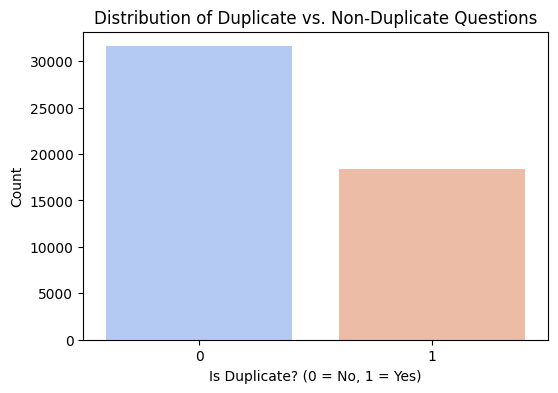

In [11]:
# Distribution of duplicate and non-duplicate questions

plt.figure(figsize=(6,4))
sns.countplot(x=df["is_duplicate"], palette="coolwarm")
plt.title("Distribution of Duplicate vs. Non-Duplicate Questions")
plt.xlabel("Is Duplicate? (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

## Text preprocessing pipeline

Preprocessing of Text
Preprocessing:

* Removing html tags
* Removing Punctuations
* Performing Lemmatization
* Performing lowercase
* Removing Stopwords
* Decontracting words
* replacing special characters with their string symbols


nltk: Used for text preprocessing and lemmatization.

os: Helps in file operations like creating directories.

shutil: Used to copy files from one location to another.

wordnet: A lexical database for the English language (used for lemmatization).

omw-1.4: Supports multilingual WordNet access.

In [12]:
import nltk
import os
import shutil

# Download wordnet manually
nltk.download('wordnet')
nltk.download('omw-1.4')

# Find where wordnet is stored
nltk_data_path = os.path.join(nltk.data.find("corpora"), "wordnet.zip")

# Ensure nltk_data exists in the Kaggle working directory
kaggle_nltk_path = "/kaggle/working/nltk_data/corpora"
os.makedirs(kaggle_nltk_path, exist_ok=True)

# Copy wordnet to the Kaggle working directory
shutil.copy(nltk_data_path, kaggle_nltk_path)

# Extract wordnet.zip
import zipfile
with zipfile.ZipFile(os.path.join(kaggle_nltk_path, "wordnet.zip"), "r") as zip_ref:
    zip_ref.extractall(kaggle_nltk_path)

print("Wordnet successfully copied and extracted!")



[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Wordnet successfully copied and extracted!


In [14]:
nltk.data.path.append("/kaggle/working/nltk_data")


This defines a preprocessing function (preprocess(q)) to clean and normalize text data before training a machine learning model. and also import librbraires for that:

re – Regular expressions for cleaning text.

BeautifulSoup – Removes HTML tags.

word_tokenize – Splits sentences into words.

stopwords – Removes common words (e.g., "the", "is", "and").

wordnet – Used for lemmatization (converting words to base form).

WordNetLemmatizer – Performs lemmatization.


In [15]:
import re
import nltk
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# Ensure necessary NLTK resources are downloaded
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords")
nltk.download("punkt")

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess(q):
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # Remove '[math]' tag
    q = q.replace('[math]', '')

    # Convert large numbers to readable format
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontract words
    contractions = {
        "can't": "cannot", "won't": "will not", "i'm": "i am", "it's": "it is", 
        "he's": "he is", "she's": "she is", "they're": "they are", "we're": "we are",
        "you're": "you are", "i've": "i have", "we've": "we have", "they've": "they have",
        "who's": "who is", "what's": "what is", "where's": "where is", "when's": "when is",
        "how's": "how is", "he'd": "he would", "she'd": "she would", "they'd": "they would",
        "we'd": "we would", "i'd": "i would", "you'd": "you would", "it'd": "it would",
        "he'll": "he will", "she'll": "she will", "they'll": "they will", "we'll": "we will",
        "you'll": "you will", "i'll": "i will", "don't": "do not", "doesn't": "does not",
        "didn't": "did not", "haven't": "have not", "hasn't": "has not", "hadn't": "had not",
        "won't": "will not", "wouldn't": "would not", "shan't": "shall not", "shouldn't": "should not",
        "can't": "cannot", "couldn't": "could not", "mightn't": "might not", "mustn't": "must not"
    }
    
    q = ' '.join([contractions[word] if word in contractions else word for word in q.split()])
    
    # Removing HTML tags
    q = BeautifulSoup(q, "html.parser").get_text()

    # Tokenization
    tokens = word_tokenize(q)
    
    # Remove punctuations and stopwords, then lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]

    # Return cleaned text
    return " ".join(tokens)


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


This applies the preprocess() function to both question columns in the dataset.

In [16]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

<ipython-input-15-1baaa961ed8a>:57: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q, "html.parser").get_text()


In [17]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,best marketing automation tool small company,best marketing automation tool small company,1
115086,115086,187729,187730,poor want invest,quite poor want rich,0
327711,327711,454161,454162,india live abroad met guy france want date,thapar university thapar university institute ...,0
367788,367788,498109,491396,many people hate southern state,boyfriend doesnt feel guilty hurt cried tellin...,0
151235,151235,237843,50930,consequence bhopal gas tragedy,reason behind bhopal gas tragedy,0


Adding some features q1_len, q2_len, q1_num_words, q2_num_words, word_commmon, word_share.

This calculates the length of each question (in characters) and stores the values in new columns.

In [18]:
df['q1_len'] = df['question1'].str.len() 
df['q2_len'] = df['question2'].str.len()

In [19]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
398782,398782,496695,532029,best marketing automation tool small company,best marketing automation tool small company,1,44,44
115086,115086,187729,187730,poor want invest,quite poor want rich,0,16,20
327711,327711,454161,454162,india live abroad met guy france want date,thapar university thapar university institute ...,0,42,88
367788,367788,498109,491396,many people hate southern state,boyfriend doesnt feel guilty hurt cried tellin...,0,31,81
151235,151235,237843,50930,consequence bhopal gas tragedy,reason behind bhopal gas tragedy,0,30,32


This calculates the number of words in each question and stores them in new columns.

In [22]:
df['q1_num_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_num_words'] = df['question2'].apply(lambda row: len(row.split(" ")))


In [23]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
398782,398782,496695,532029,best marketing automation tool small company,best marketing automation tool small company,1,44,44,6,6
115086,115086,187729,187730,poor want invest,quite poor want rich,0,16,20,3,4
327711,327711,454161,454162,india live abroad met guy france want date,thapar university thapar university institute ...,0,42,88,8,10
367788,367788,498109,491396,many people hate southern state,boyfriend doesnt feel guilty hurt cried tellin...,0,31,81,5,12
151235,151235,237843,50930,consequence bhopal gas tragedy,reason behind bhopal gas tragedy,0,30,32,4,5


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Minimum characters in Question 1: 0
Maximum characters in Question 1: 244
Average number of characters in Question 1: 35


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Minimum characters in Question 2: 0
Maximum characters in Question 2: 591
Average number of characters in Question 2: 35


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Minimum words in Question 1: 1
Maximum words in Question 1: 38
Average number of words in Question 1: 5


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Minimum words in Question 2: 1
Maximum words in Question 2: 97
Average number of words in Question 2: 5


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

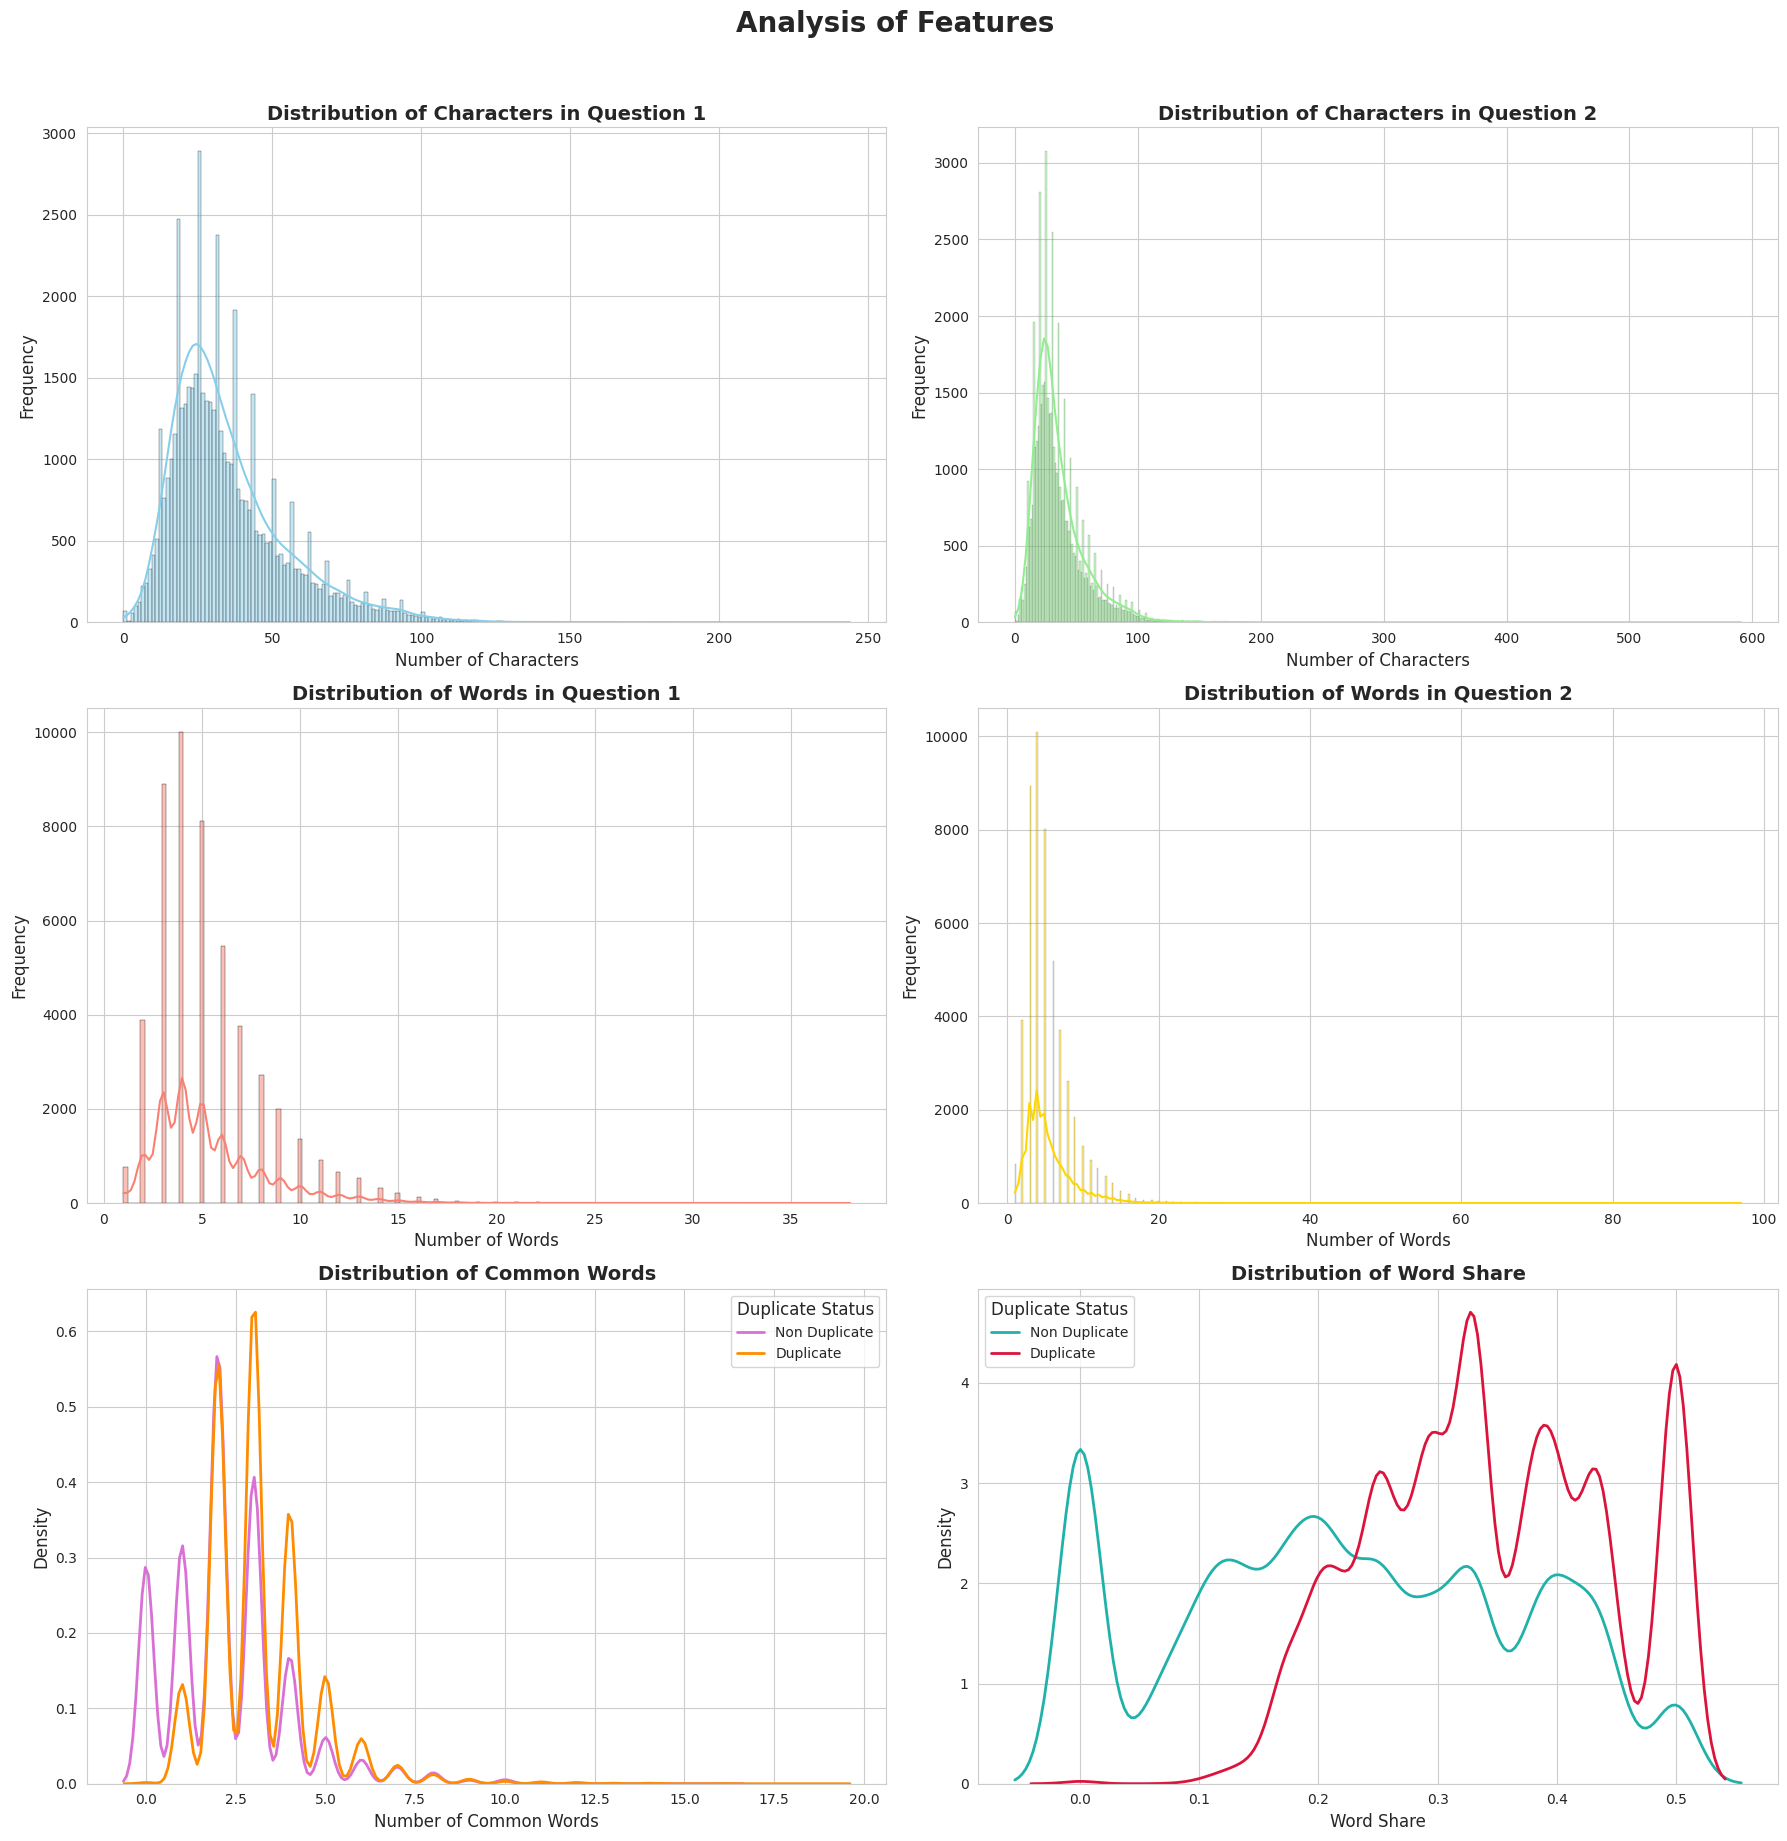

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Set up the subplot grid
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
fig.suptitle('Analysis of Features', fontsize=20, fontweight='bold', y=1.02)

# Plot 1: Distribution of characters in question1
sns.histplot(df['q1_len'], ax=axes[0, 0], kde=True, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Characters in Question 1', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Characters', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
print('Minimum characters in Question 1:', df['q1_len'].min())
print('Maximum characters in Question 1:', df['q1_len'].max())
print('Average number of characters in Question 1:', int(df['q1_len'].mean()))

# Plot 2: Distribution of characters in question2
sns.histplot(df['q2_len'], ax=axes[0, 1], kde=True, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Distribution of Characters in Question 2', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Characters', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
print('Minimum characters in Question 2:', df['q2_len'].min())
print('Maximum characters in Question 2:', df['q2_len'].max())
print('Average number of characters in Question 2:', int(df['q2_len'].mean()))

# Plot 3: Distribution of words in question1
sns.histplot(df['q1_num_words'], ax=axes[1, 0], kde=True, color='salmon', edgecolor='black')
axes[1, 0].set_title('Distribution of Words in Question 1', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Words', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
print('Minimum words in Question 1:', df['q1_num_words'].min())
print('Maximum words in Question 1:', df['q1_num_words'].max())
print('Average number of words in Question 1:', int(df['q1_num_words'].mean()))

# Plot 4: Distribution of words in question2
sns.histplot(df['q2_num_words'], ax=axes[1, 1], kde=True, color='gold', edgecolor='black')
axes[1, 1].set_title('Distribution of Words in Question 2', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Words', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
print('Minimum words in Question 2:', df['q2_num_words'].min())
print('Maximum words in Question 2:', df['q2_num_words'].max())
print('Average number of words in Question 2:', int(df['q2_num_words'].mean()))

# Plot 5: Distribution of common words for duplicate and non-duplicate pairs
sns.kdeplot(df[df['is_duplicate'] == 0]['word_common'], label='Non Duplicate', ax=axes[2, 0], color='orchid', linewidth=2)
sns.kdeplot(df[df['is_duplicate'] == 1]['word_common'], label='Duplicate', ax=axes[2, 0], color='darkorange', linewidth=2)
axes[2, 0].set_title('Distribution of Common Words', fontsize=14, fontweight='bold')
axes[2, 0].set_xlabel('Number of Common Words', fontsize=12)
axes[2, 0].set_ylabel('Density', fontsize=12)
axes[2, 0].legend(title='Duplicate Status', title_fontsize=12, fontsize=10)

# Plot 6: Distribution of word share for duplicate and non-duplicate pairs
sns.kdeplot(df[df['is_duplicate'] == 0]['word_share'], label='Non Duplicate', ax=axes[2, 1], color='lightseagreen', linewidth=2)
sns.kdeplot(df[df['is_duplicate'] == 1]['word_share'], label='Duplicate', ax=axes[2, 1], color='crimson', linewidth=2)
axes[2, 1].set_title('Distribution of Word Share', fontsize=14, fontweight='bold')
axes[2, 1].set_xlabel('Word Share', fontsize=12)
axes[2, 1].set_ylabel('Density', fontsize=12)
axes[2, 1].legend(title='Duplicate Status', title_fontsize=12, fontsize=10)

# Adjust layout and display plots
plt.tight_layout()
plt.show()


This function calculates the number of common words between question1 and question2.

In [25]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

This will calculate the number of common words for each question pair.

In [26]:
df['word_common'] = df.apply(common_words, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
398782,398782,496695,532029,best marketing automation tool small company,best marketing automation tool small company,1,44,44,6,6,6
115086,115086,187729,187730,poor want invest,quite poor want rich,0,16,20,3,4,2
327711,327711,454161,454162,india live abroad met guy france want date,thapar university thapar university institute ...,0,42,88,8,10,0
367788,367788,498109,491396,many people hate southern state,boyfriend doesnt feel guilty hurt cried tellin...,0,31,81,5,12,0
151235,151235,237843,50930,consequence bhopal gas tragedy,reason behind bhopal gas tragedy,0,30,32,4,5,3


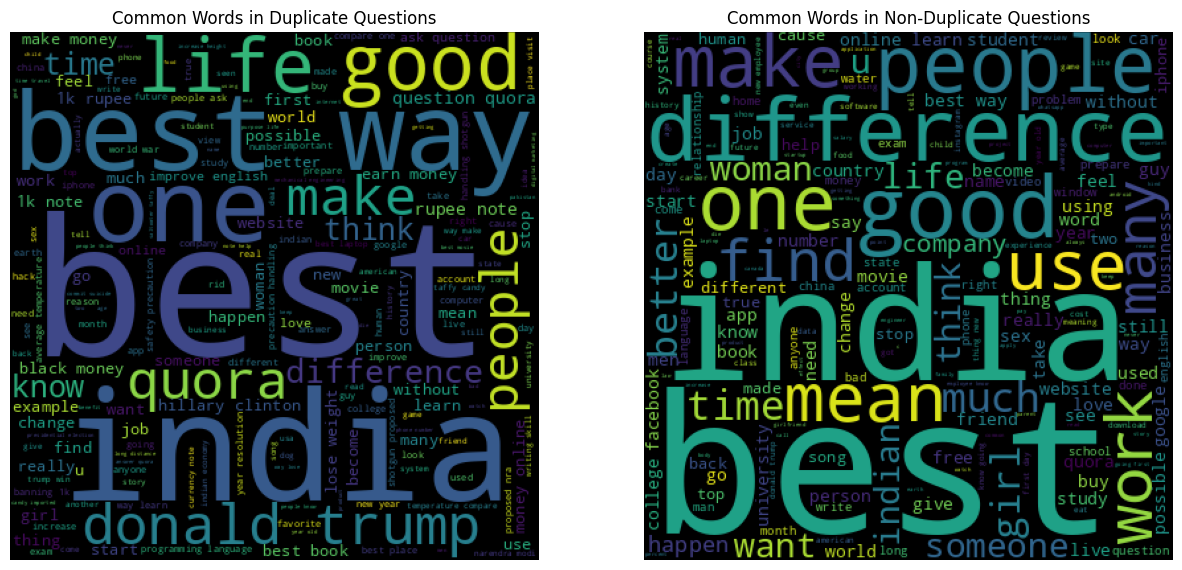

In [27]:
from wordcloud import WordCloud

duplicate_text = " ".join(df[df["is_duplicate"] == 1]["question1"])  
non_duplicate_text = " ".join(df[df["is_duplicate"] == 0]["question1"])  

fig, ax = plt.subplots(1,2, figsize=(15,7))

# Duplicate Questions
ax[0].imshow(WordCloud(width=400, height=400, background_color="black").generate(duplicate_text))
ax[0].set_title("Common Words in Duplicate Questions")
ax[0].axis("off")

# Non-Duplicate Questions
ax[1].imshow(WordCloud(width=400, height=400, background_color="black").generate(non_duplicate_text))
ax[1].set_title("Common Words in Non-Duplicate Questions")
ax[1].axis("off")

plt.show()


This function calculates the total number of unique words in both question1 and question2.

In [29]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

This applies the total_words() function to every row in the dataset and stores the result in a new column.

In [30]:
df['word_total'] = df.apply(total_words, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
398782,398782,496695,532029,best marketing automation tool small company,best marketing automation tool small company,1,44,44,6,6,6,12
115086,115086,187729,187730,poor want invest,quite poor want rich,0,16,20,3,4,2,7
327711,327711,454161,454162,india live abroad met guy france want date,thapar university thapar university institute ...,0,42,88,8,10,0,16
367788,367788,498109,491396,many people hate southern state,boyfriend doesnt feel guilty hurt cried tellin...,0,31,81,5,12,0,17
151235,151235,237843,50930,consequence bhopal gas tragedy,reason behind bhopal gas tragedy,0,30,32,4,5,3,9


This calculates the word share ratio, which measures how much of the total word count is shared between question1 and question2.

In [31]:
df['word_share'] = round(df['word_common']/df['word_total'],2)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,398782,496695,532029,best marketing automation tool small company,best marketing automation tool small company,1,44,44,6,6,6,12,0.50
115086,115086,187729,187730,poor want invest,quite poor want rich,0,16,20,3,4,2,7,0.29
327711,327711,454161,454162,india live abroad met guy france want date,thapar university thapar university institute ...,0,42,88,8,10,0,16,0.00
367788,367788,498109,491396,many people hate southern state,boyfriend doesnt feel guilty hurt cried tellin...,0,31,81,5,12,0,17,0.00
151235,151235,237843,50930,consequence bhopal gas tragedy,reason behind bhopal gas tragedy,0,30,32,4,5,3,9,0.33


### Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

This applies the fetch_token_features() function to all rows in the dataset and stores the extracted token similarity features in new columns.

In [35]:
token_features = df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

This installs the distance library, which is used for calculating text similarity based on various distance metrics.

In [37]:
!pip install distance


In [40]:
import distance

def fetch_length_features(row):
    q1 = str(row['question1'])  
    q2 = str(row['question2'])

    q1_tokens = q1.split()
    q2_tokens = q2.split()

    length_features = [0] * 3
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    length_features[1] = (len(q1_tokens) + len(q2_tokens)) / 2

    strs = list(distance.lcsubstrings(q1, q2))
    
    if strs:  
        length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    else:
        length_features[2] = 0 
    
    return length_features


length_features = df.apply(fetch_length_features, axis=1)


df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))



In [41]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [42]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
398782,398782,496695,532029,best marketing automation tool small company,best marketing automation tool small company,1,44,44,6,6,...,0.999983,0.0,0.0,0.999983,0.999983,1.0,1.0,0,6.0,0.977778
115086,115086,187729,187730,poor want invest,quite poor want rich,0,16,20,3,4,...,0.499988,0.0,0.0,0.666644,0.499988,0.0,0.0,1,3.5,0.588235
327711,327711,454161,454162,india live abroad met guy france want date,thapar university thapar university institute ...,0,42,88,8,10,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,2,9.0,0.069767
367788,367788,498109,491396,many people hate southern state,boyfriend doesnt feel guilty hurt cried tellin...,0,31,81,5,12,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,7,8.5,0.062500
151235,151235,237843,50930,consequence bhopal gas tragedy,reason behind bhopal gas tragedy,0,30,32,4,5,...,0.599988,0.0,0.0,0.749981,0.599988,1.0,0.0,1,4.5,0.612903


This installs the python-Levenshtein package, which provides fast and efficient string similarity calculations.

In [43]:
!pip install python-Levenshtein


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 66.3 MB/s eta 0:00:00:00:01


In [44]:
!pip install fuzzywuzzy

In [46]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [47]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [48]:
df.shape

(50000, 28)

In [49]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,398782,496695,532029,best marketing automation tool small company,best marketing automation tool small company,1,44,44,6,6,...,0.999983,1.0,1.0,0,6.0,0.977778,100,100,100,100
115086,115086,187729,187730,poor want invest,quite poor want rich,0,16,20,3,4,...,0.499988,0.0,0.0,1,3.5,0.588235,61,73,50,72
327711,327711,454161,454162,india live abroad met guy france want date,thapar university thapar university institute ...,0,42,88,8,10,...,0.000000,0.0,0.0,2,9.0,0.069767,35,41,32,34
367788,367788,498109,491396,many people hate southern state,boyfriend doesnt feel guilty hurt cried tellin...,0,31,81,5,12,...,0.000000,0.0,0.0,7,8.5,0.062500,30,42,32,32
151235,151235,237843,50930,consequence bhopal gas tragedy,reason behind bhopal gas tragedy,0,30,32,4,5,...,0.599988,1.0,0.0,1,4.5,0.612903,74,79,61,75


a new DataFrame containing only the question1 and question2 columns.

In [50]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
398782,best marketing automation tool small company,best marketing automation tool small company
115086,poor want invest,quite poor want rich
327711,india live abroad met guy france want date,thapar university thapar university institute ...
367788,many people hate southern state,boyfriend doesnt feel guilty hurt cried tellin...
151235,consequence bhopal gas tragedy,reason behind bhopal gas tragedy


removes unnecessary columns and keeps only the engineered features + target variable (is_duplicate).

In [51]:
final_df = df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(50000, 23)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,1,44,44,6,6,6,12,0.50,0.999983,0.999983,...,0.999983,1.0,1.0,0,6.0,0.977778,100,100,100,100
115086,0,16,20,3,4,2,7,0.29,0.666644,0.499988,...,0.499988,0.0,0.0,1,3.5,0.588235,61,73,50,72
327711,0,42,88,8,10,0,16,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,2,9.0,0.069767,35,41,32,34
367788,0,31,81,5,12,0,17,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,7,8.5,0.062500,30,42,32,32
151235,0,30,32,4,5,3,9,0.33,0.749981,0.599988,...,0.599988,1.0,0.0,1,4.5,0.612903,74,79,61,75


####  TF-IDF (Term Frequency-Inverse Document Frequency) vectorization 
to convert the text questions into numerical features.

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


questions = list(ques_df['question1']) + list(ques_df['question2'])

tfidf = TfidfVectorizer(max_features=3000)


tfidf_matrix = tfidf.fit_transform(questions).toarray()

q1_arr, q2_arr = np.vsplit(tfidf_matrix, 2)


This converts the TF-IDF vectors into DataFrames and merges them into a single feature matrix.

In [53]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(50000, 6000)

In [54]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(50000, 6023)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
398782,1,44,44,6,6,6,12,0.50,0.999983,0.999983,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115086,0,16,20,3,4,2,7,0.29,0.666644,0.499988,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
327711,0,42,88,8,10,0,16,0.00,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367788,0,31,81,5,12,0,17,0.00,0.000000,0.000000,...,0.0,0.0,0.328081,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151235,0,30,32,4,5,3,9,0.33,0.749981,0.599988,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model building and training

The percentage of data splitting in this code is 80% training data and 20% test data.

In [56]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)
print("X_train shape:", X_train.shape)  
print("X_test shape:", X_test.shape)


X_train shape: (40000, 6022)
X_test shape: (10000, 6022)


### Decision Tree Classifier

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dt_model = DecisionTreeClassifier()  # Initialize Decision Tree model
dt_model.fit(X_train, y_train)  # Train the model

y_pred_dt = dt_model.predict(X_test)  # Make predictions
dt_accuracy = accuracy_score(y_test, y_pred_dt)  # Calculate accuracy

print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")


Decision Tree Accuracy: 0.73


### Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Calculate accuracy
accuracy_score(y_test, y_pred)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7624

### Random Forest Classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7788

### XGB Classifier

In [60]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.775

## Model Creation: 
### ANN Model with Keras

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define ANN Model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Print Model Summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6434 - loss: 0.6387 - val_accuracy: 0.7033 - val_loss: 0.5123
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7006 - loss: 0.5179 - val_accuracy: 0.7504 - val_loss: 0.4860
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7168 - loss: 0.4996 - val_accuracy: 0.7570 - val_loss: 0.4720
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7150 - loss: 0.4915 - val_accuracy: 0.7353 - val_loss: 0.4640
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7347 - loss: 0.4716 - val_accuracy: 0.7653 - val_loss: 0.4571
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7398 - loss: 0.4658 - val_accuracy: 0.7586 - val_loss: 0.4692
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7409 - loss: 0.4647 - val_accuracy: 0.7531 - val_loss: 0.4660
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7501 - loss: 0.4521 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │       3,083,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,744,389 (37.17 MB)

 Trainable params: 3,248,129 (12.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,496,260 (24.78 MB)

#### LSTM for Sequence-Based Learning

In [62]:
from tensorflow.keras.layers import LSTM, Embedding

lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=X_train.shape[1]),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 580s 461ms/step - accuracy: 0.6342 - loss: 0.6583 - val_accuracy: 0.6285 - val_loss: 0.6598
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 579s 463ms/step - accuracy: 0.6364 - loss: 0.6557 - val_accuracy: 0.6285 - val_loss: 0.6599
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 583s 467ms/step - accuracy: 0.6304 - loss: 0.6589 - val_accuracy: 0.6285 - val_loss: 0.6600
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 586s 469ms/step - accuracy: 0.6372 - loss: 0.6553 - val_accuracy: 0.6285 - val_loss: 0.6598
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 586s 469ms/step - accuracy: 0.6305 - loss: 0.6590 - val_accuracy: 0.6285 - val_loss: 0.6607
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 586s 469ms/step - accuracy: 0.6312 - loss: 0.6587 - val_accuracy: 0.6285 - val_loss: 0.6598
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 586s 469ms/step - accuracy: 0.6335 - loss: 0.6574 - val_accuracy: 0.6285 - val_loss: 0.6598
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 586s 469ms/step - ac

## Model Evaluation
#### Evaluate Model with Accuracy, Precision, Recall, and F1-Score of random forest

Accuracy: 0.7788
Precision: 0.7285
Recall: 0.6450
F1 Score: 0.6842


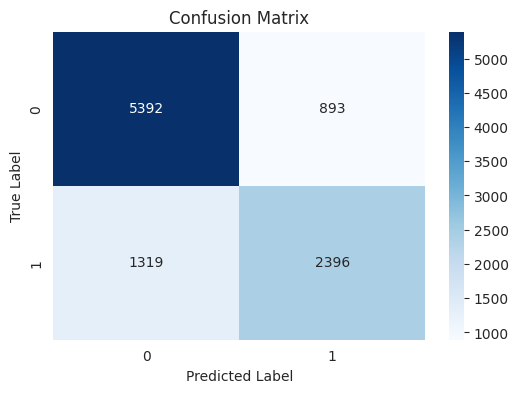

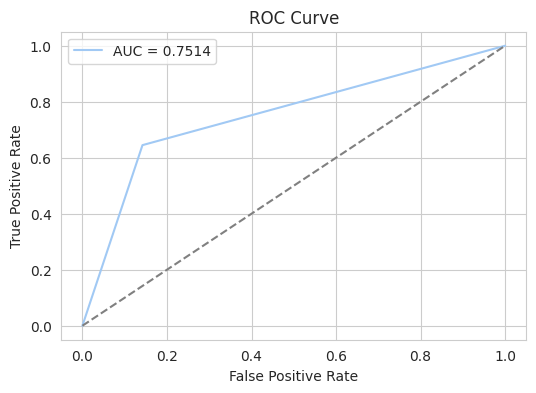

In [127]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Predict Probabilities
y_pred_probs = rf.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to 0/1

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


#### Grid Search for Hyperparameter Optimization

In [64]:
!pip install keras-tuner


In [65]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential([
        Dense(hp.Int("units", 128, 512, step=128), activation="relu", input_shape=(X_train.shape[1],)),
        Dropout(hp.Choice("dropout", [0.3, 0.5])),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, directory="tuner_results"
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
best_model = tuner.get_best_models(num_models=1)[0]


Trial 5 Complete [00h 00m 30s]
val_accuracy: 0.7757999897003174

Best val_accuracy So Far: 0.7764000296592712
Total elapsed time: 00h 02m 34s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [66]:
from sklearn.metrics import confusion_matrix

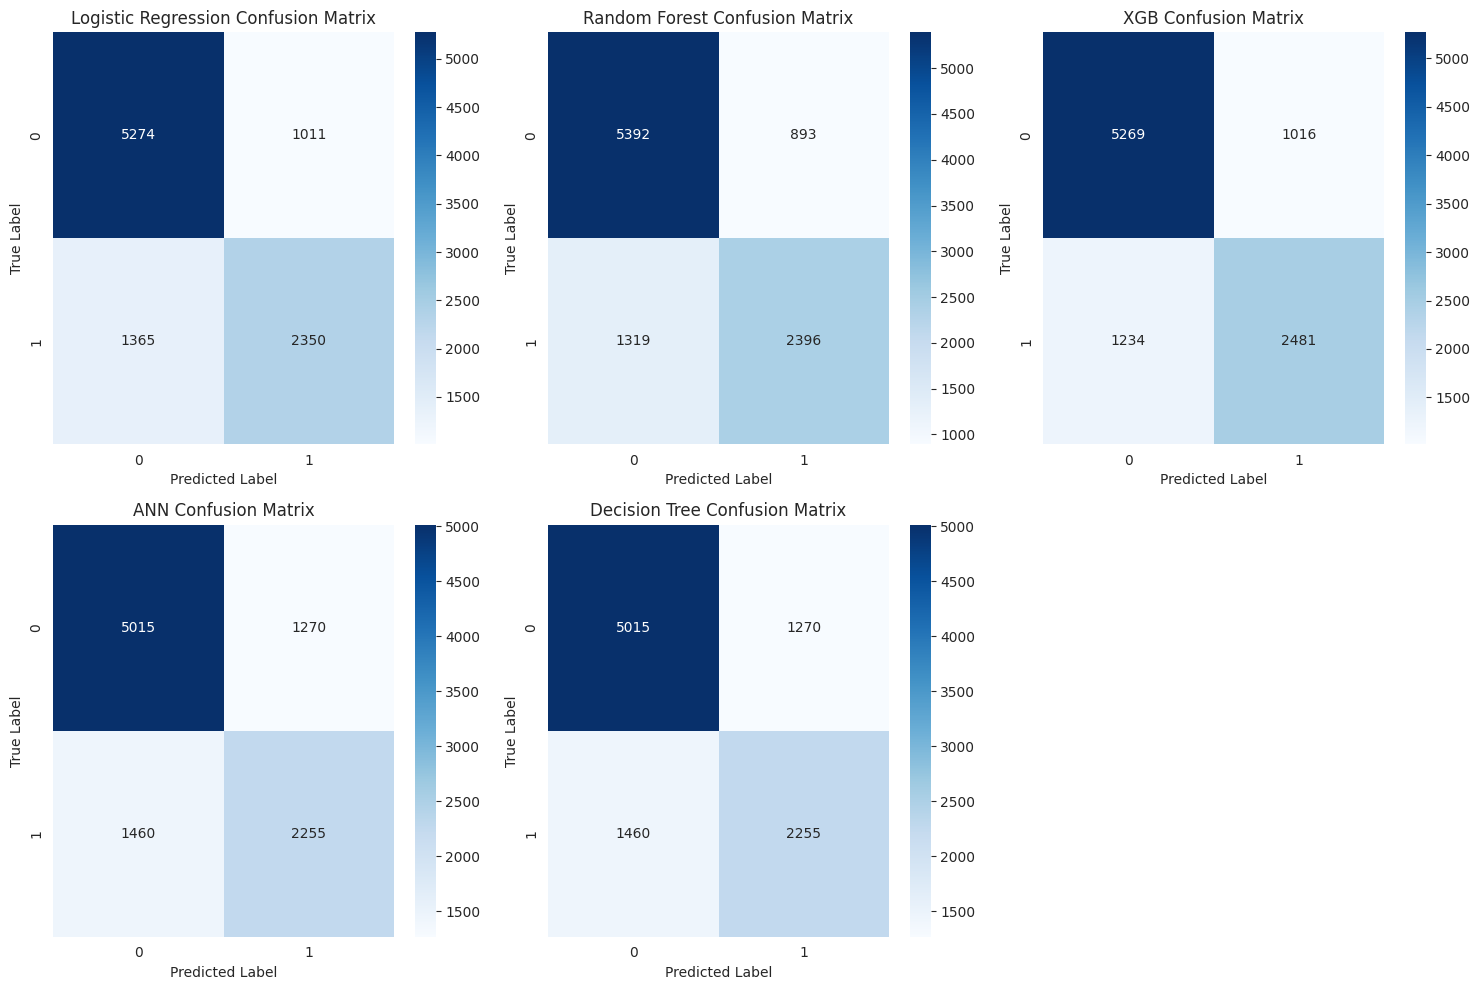

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Assuming you have trained these models
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "XGB": xgb,
    "ANN": model,  # Your trained ANN (Keras/TensorFlow model)
    "Decision Tree": dt_model  # Your trained Decision Tree model
}

# Store evaluation metrics dynamically
conf_matrices = {}

for name, model in models.items():
    if name == "ANN":  
        y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()  # Convert ANN output to binary
    else:
        y_pred = model.predict(X_test)

    # Compute Confusion Matrix
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# Determine grid size for plotting confusion matrices
num_models = len(models)
rows = (num_models // 3) + (num_models % 3 > 0)  # 2 rows for better visibility
cols = 3 if num_models > 3 else num_models  # Max 3 columns

# Plot Confusion Matrices in 2x3 Grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()  # Flatten for easier looping

for idx, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[idx])
    axes[idx].set_title(f"{name} Confusion Matrix")
    axes[idx].set_xlabel("Predicted Label")
    axes[idx].set_ylabel("True Label")

# Hide empty subplots if models are less than 6
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


Here we can see random forest (0,1) is smaller score than any other and it make sense to use this model though xgboost has same accuracy.

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from tabulate import tabulate

# Assuming you have trained these models
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "XGB": xgb,
    "ANN": model,  # Your trained Keras/TensorFlow model
    "Decision Tree": dt_model  # Your trained Decision Tree model
}

# Store evaluation metrics dynamically
accuracy_scores = []
f1_scores = []

for name, model in models.items():
    if name == "ANN":  
        # ANN requires a different prediction format
        y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()  
    else:
        y_pred = model.predict(X_test)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Create DataFrame
df_scores = pd.DataFrame({"Model": models.keys(), "Accuracy": accuracy_scores, "F1-Score": f1_scores})

# Display results as a formatted table
table = tabulate(df_scores, headers="keys", tablefmt="fancy_grid")
print(table)



╒════╤═════════════════════╤════════════╤════════════╕
│    │ Model               │   Accuracy │   F1-Score │
╞════╪═════════════════════╪════════════╪════════════╡
│  0 │ Logistic Regression │     0.7624 │   0.664217 │
├────┼─────────────────────┼────────────┼────────────┤
│  1 │ Random Forest       │     0.7788 │   0.68418  │
├────┼─────────────────────┼────────────┼────────────┤
│  2 │ XGB                 │     0.775  │   0.68802  │
├────┼─────────────────────┼────────────┼────────────┤
│  3 │ ANN                 │     0.727  │   0.622928 │
├────┼─────────────────────┼────────────┼────────────┤
│  4 │ Decision Tree       │     0.727  │   0.622928 │
╘════╧═════════════════════╧════════════╧════════════╛


In [104]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [105]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

In [106]:
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [107]:
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [108]:
def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [109]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_bow = tfidf.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = tfidf.transform([q2]).toarray()
    
    
    
    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [112]:
q1 = 'how a picture draw?'
q2 = 'how picture can be draw?'

In [113]:
rf.predict(query_point_creator(q1,q2))

array([1])

In [ ]:
import pickle

pickle.dump(rf,open('model.pkl','wb'))
